# Анализ бизнес-показателей рекламной кампании развлекательного приложения Procrastinate Pro+
# Введение

В проекте рассматривается рекламная кампания развлекательного приложения `Procrastinate Pro+`. Необходимо проанализировать, почему при вложениях в рекламу проект все равно финансово убыточен. 

Основные задачи, поставленные для решения в данном проекте: 
- Выяснить, окупается ли текущая рекламная кампания. 
- Какие устройства, страны и каналы могут снижать окупаемость рекламы. 
- Предположить, с чем связаны проблемы окупаемости приложения.

В процессе работы над проектом были сделаны следующие действия: 
- Подготовка данных для последующей обработки.
- Задание функций для создания профилей, расчёта удержания, конверсии, LTV и ROI.
- Проведен исследовательский анализ данных: создание профилей клиента; изучение стран и предпочитаемых устройств клиентов, а также рекламных источников привлечения. 
- Анализ маркетинговых расходов и расчет стоимости привлечения пользователя. 
- Анализ окупаемости рекламы на основании анализа графиков `LTV`, `ROI` и `CAC`.
- Выводы и рекомендации на основании проведенного исследования.

# 1. Загрузка данных и подготовка к анализу

Импортируем библиотеки, которые понадобятся для работы, загрузим данные и проверим при помощи атрибута `info()` каждый датафрейм на корректность заполнения:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    visits = pd.read_csv(r'C:\Users\Seal\PycharmProjects\datasets\visits_info_short.csv')
    orders = pd.read_csv(r'C:\Users\Seal\PycharmProjects\datasets\orders_info_short.csv')
    costs = pd.read_csv(r'C:\Users\Seal\PycharmProjects\datasets\costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


В загруженных датафреймах `visits`, `orders`, `costs` нет пропусков данных, но:
- некорректно названы колонки,
- колонки с датами нужно перевести в формат `datetime`.
Сделаем это и заодно проверим, есть ли дубликаты строк в датафреймах:

In [6]:
print(visits.duplicated().sum()) #проверка датафреймов на дубликаты
print(orders.duplicated().sum())
costs.duplicated().sum()

0
0


0

In [7]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end'] #изменяем имена колонок
visits['session_start'] = pd.to_datetime(visits['session_start'])  #изменяем тип колонки на datetime
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders.columns = ['user_id', 'event_dt', 'revenue']
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs.columns = ['dt', 'channel', 'costs']
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Проверим также категориальные данные - нет ли дубликатов или каких-то ошибок в данных: 

In [8]:
print(visits['region'].value_counts())             #проверяем столбцы дф visits
print()
print(visits['device'].value_counts())
print()
visits['channel'].value_counts()

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64



organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

In [9]:
costs['channel'].value_counts()        #проверяем столбцы дф costs

FaceBoom              180
LeapBob               180
OppleCreativeMedia    180
YRabbit               180
AdNonSense            180
MediaTornado          180
RocketSuperAds        180
lambdaMediaAds        180
WahooNetBanner        180
TipTop                180
Name: channel, dtype: int64

Итак, мы загрузили 3 датафрейма с данными:
- `visits`- информация о визитах пользователей (включает в себя уникальный номер пользователя, устройство входа, дату начала и конца сессии),
- `orders` - информация о покупках пользователей в приложении, 
- `costs` - информация затратах на рекламную кампанию в различных источниках. 

После проверки категориальных данных видно, что: 
- в данных нет ошибок и дубликатов,
- пользователи приложения находятся в четырех странах: 3 в Европе и 1 - в Северной Америке,
- приложение доступно на четырех устройствах (`IPhone`, `Android`, `PC` и `Mac`),
- пользователи приходят в приложение из 10 рекламных каналов, а также органически (бесплатно). 

Все датафреймы прошли предобработку, можно начинать работу с данными. 

# 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

Зададим функции, необходимые для анализа данных: 
- `get_profiles()` - создание профилей пользователей,
- `get_retention()` - расчет удержания, 
- `get_conversion()` - расчет конверсии, 
- `get_ltv()` - расчет LTV и ROI, 
- `filter_data()` - сглаживание фрейма, 
- `plot_retention()` - визуализация удержания, 
- `plot_conversion()` - визуализация конверсии, 
- `plot_ltv_roi()` - визуализация LTV и ROI.

Данные функции будем использовать для последующего анализа и визуализации данных.

### Функция для создания профилей пользователей - `get_profiles()` 

In [10]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для расчета удержания - `get_retention()` 


In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета конверсии - `get_conversion()`  


In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта LTV и ROI - `get_ltv()`

In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для сглаживания фрейма - `filter_data()`

In [14]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Функция для визуализации удержания - `plot_retention()`

In [15]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для визуализации конверсии - `plot_conversion()`

In [16]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визуализации LTV и ROI - `plot_ltv_roi()`

In [17]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# 3. Исследовательский анализ данных
##  3.1 Создание пользовательского профиля

Проведем исследовательский анализ данных и для начала создадим пользовательские профили и выясним максимальную и минимальную дату привлечения пользователей. 
Для создания профилей воспользуюсь функцией, заданной выше - `get_profiles()`.

In [18]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную дату привлечения пользователей, а также рассчитаем промежуток между этими датами:

In [19]:
print(f"Минимальная дата привлечения пользователей: {profiles['dt'].min()}")
print(f"Максимальная дата привлечения пользователей: {profiles['dt'].max()}")
print(f"Временной промежуток исследования - {(profiles['dt'].max() - profiles['dt'].min()).days} дней")

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27
Временной промежуток исследования - 179 дней


Как видно, в датафрейме приведены данные с мая до 27 октября 2019 г. Согласно условиям, момент данных - 01.11.2019 г., а горизонт данных- 2 недели. Соответственно, для нашего анализа не подходят пользователи с датой регистрации позднее 13.10.2019 г., т.к. они не успели прожить весь лайфтайм до окончания нашей выгрузки. Для анализа будем использовать данные пользователей с датой регистрации с 01.05.2019 по 13.10.2019 г.

## 3.2 Изучение стран пользователей
Исследуем, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

In [20]:
pr_users = profiles.pivot_table(index = 'region', values = 'payer', 
                                                        aggfunc = 'count').sort_values(by = 'payer')
pr_users.columns = ['country']
pr_users['percent'] = round(pr_users['country'].div(pr_users['country'].sum(), axis = 0)*100, 2)
pr_users = pr_users.sort_values(by = 'percent', ascending = False)
pr_users.head() #выборка стран пользователей

,country,percent
region,,
United States,100002,66.66
UK,17575,11.72
France,17450,11.63
Germany,14981,9.99


In [21]:
pr_payers = profiles.query('payer == True').pivot_table(index = 'region', values = 'payer', 
                                                        aggfunc = 'count').sort_values(by = 'payer')
pr_payers.columns = ['country']
pr_payers['percent'] = round(pr_payers['country'].div(pr_payers['country'].sum(), axis = 0)*100, 2)
pr_payers = pr_payers.sort_values(by = 'percent', ascending = False)
pr_payers.head()  #выборка стран платящих пользователей

,country,percent
region,,
United States,6902,77.72
UK,700,7.88
France,663,7.47
Germany,616,6.94


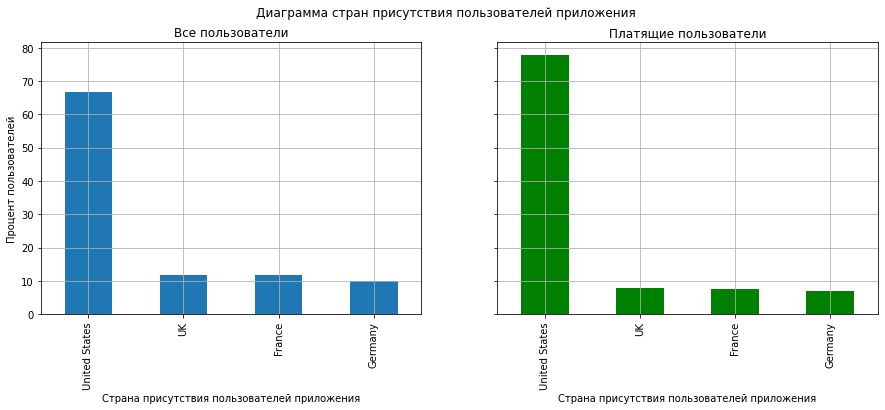

In [22]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Диаграмма стран присутствия пользователей приложения")

ax1 = plt.subplot(1, 2, 1)
pr_users['percent'].plot(kind = 'bar', grid = True, xlabel = 'Страна присутствия пользователей приложения', 
                        ylabel = 'Процент пользователей', title = 'Все пользователи')

ax2 = plt.subplot(1, 2, 2, sharey = ax1)
pr_payers['percent'].plot(kind = 'bar', grid = True, xlabel = 'Страна присутствия пользователей приложения', 
                        ylabel = 'Процент пользователей', title = 'Платящие пользователи', color = 'green')

plt.show()

Из построенных графиков видно, что больше всего пользователей находится в `США` (66.66% от общего количества и 77.72%- среди платящих пользователей). Также представлены такие страны, как:
- `Великобритания` (11,72% - общая выборка, 7.88% - платящие пользователи),
- `Франция` (11.63% - общая выборка, 7.47% - платящие пользователи),
- `Германия` (9.99% - общая выборка, 6.94% - платящие пользователи).

Проверим конверсию среди пользователей из разных стран:

In [23]:
conv_region = profiles.pivot_table(index = 'region', values = 'user_id', aggfunc = 'count').merge(
    profiles.query('payer == True').pivot_table(index = 'region',values = 'payer', aggfunc = 'count'), on = 'region')
conv_region['conversion'] = round((conv_region['payer']/conv_region['user_id'])*100, 2)
conv_region

,user_id,payer,conversion
region,,,
France,17450,663,3.80
Germany,14981,616,4.11
UK,17575,700,3.98
United States,100002,6902,6.90


<AxesSubplot:title={'center':'Конверсия пользователей из разных стран'}, xlabel='region'>

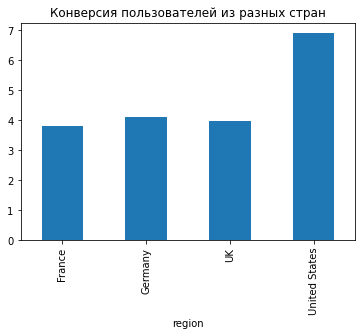

In [24]:
conv_region['conversion'].plot(kind = 'bar', title = 'Конверсия пользователей из разных стран')

Виндно, что: 
- лучше всего конвертируются пользователи из США (6.90%),
- конверсия пользователей из Европы ниже и находится примерно на одном уровне (4%). 

В нашем исследовании стоит ориентироваться на лидера конверсии - это США, но также рассматривать и Европейские страны как абсолютно иной рынок сбыта.

## 3.3 Изучение устройств пользователей
Исследуем, какими устройствами пользуются клиенты приложения и какая конверсия у каждого из устройств. 
Для этого найдем долю каждого из устройств и посчитаем конверсию: 

In [25]:
gadgets_users = profiles.pivot_table(index = 'device', values = 'payer', 
                                                        aggfunc = 'count').sort_values(by = 'payer')
gadgets_users.columns = ['gadgets']
gadgets_users['percent'] = round(gadgets_users['gadgets'].div(gadgets_users['gadgets'].sum(), axis = 0)*100, 2)
gadgets_users = gadgets_users.sort_values(by = 'percent', ascending = False)
gadgets_users.head() #выборка устройств пользователей

,gadgets,percent
device,,
iPhone,54479,36.32
Android,35032,23.35
PC,30455,20.30
Mac,30042,20.03


In [26]:
gadgets_payers = profiles.pivot_table(index = 'device', values = 'user_id', aggfunc = 'count').merge(
    profiles.query('payer == True').pivot_table(index = 'device',values = 'payer', aggfunc = 'count'), on = 'device')
gadgets_payers['conversion'] = round((gadgets_payers['payer']/gadgets_payers['user_id'])*100, 2)
gadgets_payers

,user_id,payer,conversion
device,,,
Android,35032,2050,5.85
Mac,30042,1912,6.36
PC,30455,1537,5.05
iPhone,54479,3382,6.21


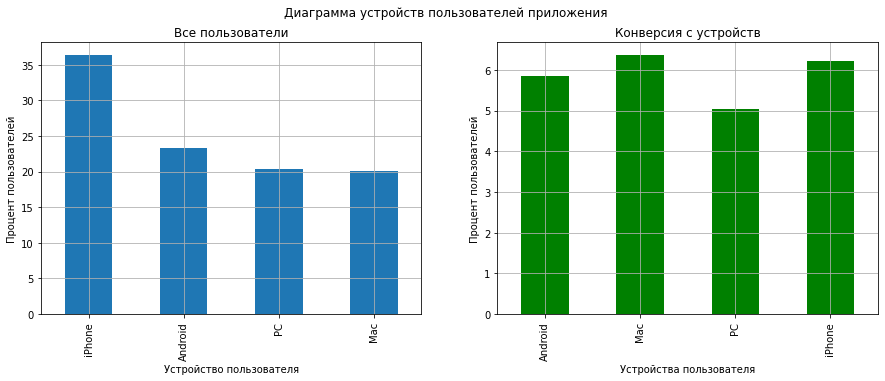

In [27]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Диаграмма устройств пользователей приложения")

ax1 = plt.subplot(1, 2, 1)
gadgets_users['percent'].plot(kind = 'bar', grid = True, xlabel = 'Устройство пользователя', 
                        ylabel = 'Процент пользователей', title = 'Все пользователи')

ax2 = plt.subplot(1, 2, 2)
gadgets_payers['conversion'].plot(kind = 'bar', grid = True, xlabel = 'Устройства пользователя', 
                        ylabel = 'Процент пользователей', title = 'Конверсия с устройств', color = 'green')

plt.show()

Видно, что среди устройств лидирует `IPhone` (36.32% среди всех пользователей), далее идут устройства на платформе `Android` (23.35% ). На третьем и четвертом месте- `PC` и `Mac`, причем среди всех пользователей доля этих платформ примерно равна (20.30% - РС, 20.03% - Мас). 
А вот если рассмотреть конверсию, то она находится примерно на одном уровне, лидеры конверсии -  `Mac` (6.36%), `IPhone` (6.21%), далее  `Android` (5.85%) и хуже всех конверсия `PC` (5.05%). 
Можно сделать вывод, что стоит обратить внимание на приложение именно для `IPhone`и `Mac` как устройств с самой высокой конверсией, однако я предлагаю сделать выборку распределения устройств по странам пользователей и посмотреть, изменится ли общая картина. 

In [28]:
gadgets_country_conv =  profiles.pivot_table(columns = 'region', index = 'device', values = 'payer', 
                        aggfunc = 'count').merge(profiles.query('payer == True').pivot_table(columns = 'region', 
                        index = 'device', values = 'payer', aggfunc = 'count'), on = 'device')

gadgets_country_conv['France_conv'] = round((gadgets_country_conv['France_y'] / gadgets_country_conv['France_x'])*100,2)
gadgets_country_conv['Germany_conv'] = round((gadgets_country_conv['Germany_y'] / gadgets_country_conv['Germany_x'])*100,2)
gadgets_country_conv['UK_conv'] = round((gadgets_country_conv['UK_y'] / gadgets_country_conv['UK_x'])*100,2)
gadgets_country_conv['United States_conv'] = round((gadgets_country_conv['United States_y'] / 
                                                    gadgets_country_conv['United States_x'])*100,2)

gadgets_country_conv = gadgets_country_conv[['France_conv', 'Germany_conv', 'UK_conv', 'United States_conv']]
gadgets_country_conv.columns = ['FR', 'GE', 'UK', 'USA']
gadgets_country_conv

,FR,GE,UK,USA
device,,,,
Android,3.41,4.10,3.93,7.36
Mac,4.46,3.85,3.54,6.87
PC,3.86,4.26,4.22,6.85
iPhone,3.92,3.98,3.81,6.72


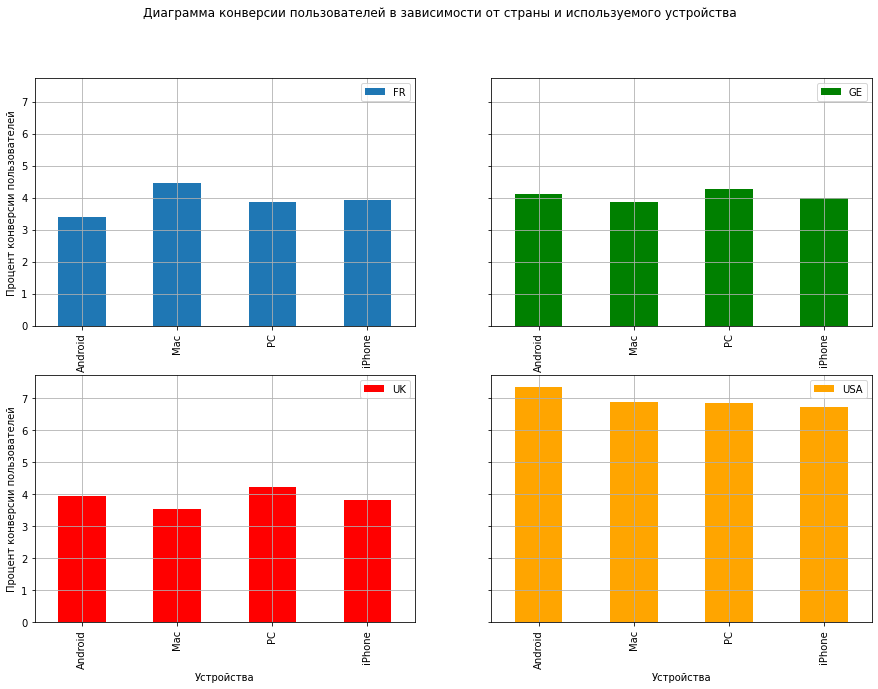

In [29]:
fig = plt.figure(figsize=(15, 10))
plt.suptitle("Диаграмма конверсии пользователей в зависимости от страны и используемого устройства")

ax1 = plt.subplot(2, 2, 1)
gadgets_country_conv['FR'].plot(kind = 'bar', grid = True, xlabel = 'Устройства', 
                        ylabel = 'Процент конверсии пользователей')
ax1.legend()

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
gadgets_country_conv['GE'].plot(kind = 'bar', grid = True, xlabel = 'Устройства', 
                        ylabel = 'Процент конверсии пользователей', color = 'green')
ax2.legend()

ax3 = plt.subplot(2, 2, 3, sharey = ax1)
gadgets_country_conv['UK'].plot(kind = 'bar', grid = True, xlabel = 'Устройства', 
                        ylabel = 'Процент конверсии пользователей', color = 'red')
ax3.legend()

ax4 = plt.subplot(2, 2, 4, sharey = ax1)
gadgets_country_conv['USA'].plot(kind = 'bar', grid = True, xlabel = 'Устройства', 
                        ylabel = 'Процент конверсии пользователей', color = 'orange')
ax4.legend()

plt.show()

Как видим, при рассмотрении конверсии пользователей в зависимости от страны и устройства, ситуация сильно не меняется. 
- Конверсия Европейских пользователей находится на уровне 4%.
- Конверсия пользователей из США- на уровне 7%.

Конверсия устройств внутри стран также находится примерно на одном уровне, но все-таки выделим лидеров: 
- Франция: `Mac` (4.46%),
- Германия: `PC` (4.26%),
- Великобритания: `PC` (4.22%),
- США: `Android` (7.36%). 

По итогам модуля можно сказать, что лучше всего конвертируются пользователи с платформ `IPhone` и `Mac`, однако если смотреть конверсию по устройствам в разрезе стран пользователей - это преимущество не является таким неоспоримым. Опять же в лидеры конверсии, как и в прошлом пункте, выбивается США. 

## 3.4 Рекламные источники привлечения пользователей
Исследуем, каналы привлечения пользователей и определим, из каких каналов пришло больше всего платящих пользователей

In [30]:
channel_users = profiles.pivot_table(index = 'channel', values = 'payer', 
                                                        aggfunc = 'count').sort_values(by = 'payer')

channel_users.columns = ['channel_count']
channel_users['percent'] = round(channel_users['channel_count'].div(channel_users['channel_count'].sum(), axis = 0)*100, 2)
channel_users = channel_users.sort_values(by = 'percent', ascending = False)
channel_users #выборка рекламных источников привлечения по всем пользователям

,channel_count,percent
channel,,
organic,56439,37.62
FaceBoom,29144,19.43
TipTop,19561,13.04
OppleCreativeMedia,8605,5.74
LeapBob,8553,5.70
WahooNetBanner,8553,5.70
RocketSuperAds,4448,2.97
MediaTornado,4364,2.91
YRabbit,4312,2.87


In [31]:
channel_conv = profiles.pivot_table(index = 'channel', values = 'user_id', aggfunc = 'count').merge(
    profiles.query('payer == True').pivot_table(index = 'channel',values = 'payer', aggfunc = 'count'), on = 'channel')
channel_conv['conversion'] = round((channel_conv['payer']/channel_conv['user_id'])*100, 2)
channel_conv #расчет конверсии из каждого канала

,user_id,payer,conversion
channel,,,
AdNonSense,3880,440,11.34
FaceBoom,29144,3557,12.20
LeapBob,8553,262,3.06
MediaTornado,4364,156,3.57
OppleCreativeMedia,8605,233,2.71
RocketSuperAds,4448,352,7.91
TipTop,19561,1878,9.60
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83


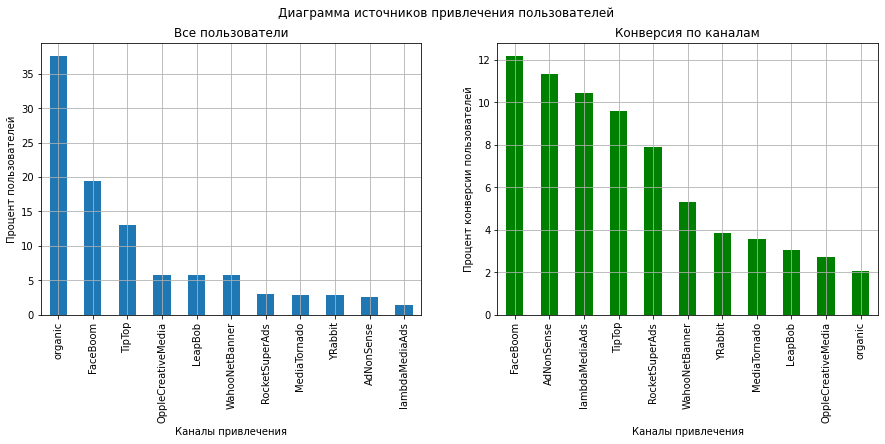

In [32]:
# построим диаграмму источников привлечения пользователей
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Диаграмма источников привлечения пользователей")

ax1 = plt.subplot(1, 2, 1)
channel_users['percent'].plot(kind = 'bar', grid = True, xlabel = 'Каналы привлечения', 
                        ylabel = 'Процент пользователей', title = 'Все пользователи')

ax2 = plt.subplot(1, 2, 2)
channel_conv['conversion'].sort_values(ascending = False).plot(kind = 'bar', grid = True, xlabel = 'Каналы привлечения', 
                        ylabel = 'Процент конверсии пользователей', title = 'Конверсия по каналам', color = 'green')

plt.show()

Как видно из диаграмм, больше всего пользователей приходит из канала `Organic` (т.е. бесплатно) - 37.62% от всех пользователей.
<a id='organic'></a> Однако если посмотреть конверсию, канал `Organic` находится на последнем месте и имеет конверсию всего в 2.06%. 
Тройка самых популярных источников привлечения:
- `Organic`: 37.62% всех пользователей (1 место), конверсия - 2.06% (11 место), 
- `FaceBoom	`: 19.43% всех пользователей (2 место), конверсия - 12.20% (1 место),  
- `TipTop`: 13.04% всех пользователей (3 место), конверсия - 9.60% (4 место)

Лидерами конверсии являются следующие источники: 
- `FaceBoom	`  - 12.20%,
- `AdNonSense` - 11.34%,
- `lambdaMediaAds` - 10.47%,
- `TipTop` - 9.60%. 

Однако эта выборка затрагивает все страны, в которых представлено приложение. Опять же, в каждом регионе могут быть свои особенности. Рассмотрим конверсию источников привлечения с учетом стран.  

In [33]:
channel_countryes_conv =  profiles.pivot_table(columns = 'region', index = 'channel', values = 'user_id', 
                        aggfunc = 'count').merge(profiles.query('payer == True').pivot_table(columns = 'region', 
                        index = 'channel', values = 'payer', aggfunc = 'count'), on = 'channel')

channel_countryes_conv['FR'] = round((channel_countryes_conv['France_y'] / channel_countryes_conv['France_x'])*100,2)
channel_countryes_conv['GR'] = round((channel_countryes_conv['Germany_y'] / channel_countryes_conv['Germany_x'])*100,2)
channel_countryes_conv['UK'] = round((channel_countryes_conv['UK_y'] / channel_countryes_conv['UK_x'])*100,2)
channel_countryes_conv['USA'] = round((channel_countryes_conv['United States_y'] / 
                                       channel_countryes_conv['United States_x'])*100,2)

channel_countryes_conv = channel_countryes_conv[['FR', 'GR', 'UK', 'USA']]
channel_countryes_conv

region,FR,GR,UK,USA
channel,,,,
AdNonSense,10.98,11.65,11.43,NaN
FaceBoom,NaN,NaN,NaN,12.20
LeapBob,3.01,2.74,3.38,NaN
MediaTornado,NaN,NaN,NaN,3.57
OppleCreativeMedia,2.67,2.50,2.92,NaN
RocketSuperAds,NaN,NaN,NaN,7.91
TipTop,NaN,NaN,NaN,9.60
WahooNetBanner,5.12,5.74,5.09,NaN
YRabbit,NaN,NaN,NaN,3.83


Как видно из таблицы выше, в каждом регионе есть свои популярные рекламные источники привлечения пользователей и практически все из них представлены либо только в Европейском регионе, либо в США. <a id='oregion'></a> Только `Organic` представлен во всех регионах (что и понятно, здесь пользователи сами находят интересующее приложение). Построим графики и посмотрим, как рекламные источники конвертируются в разных странах:

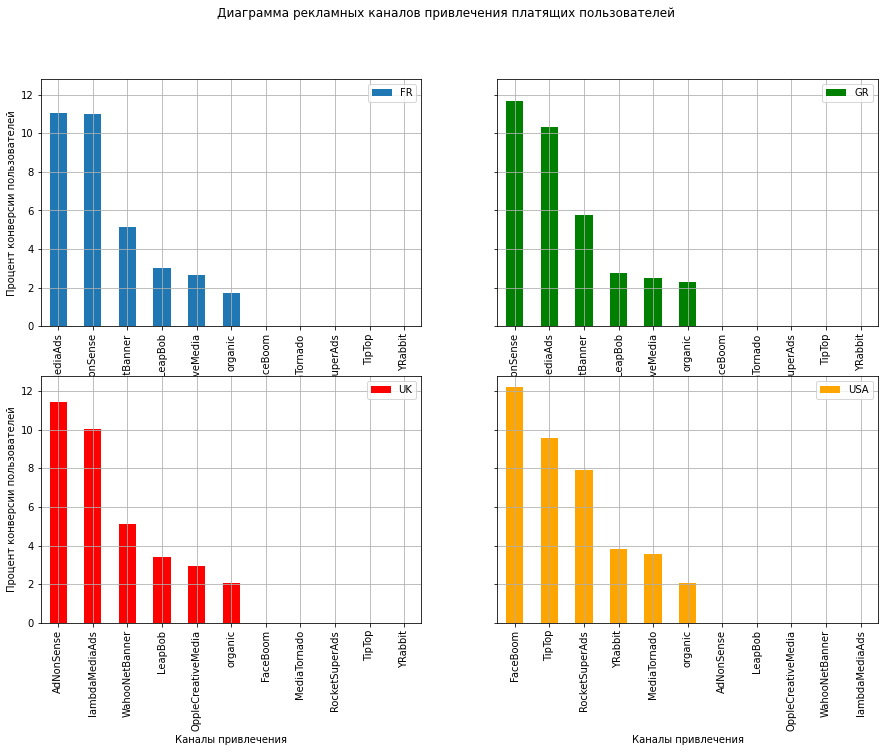

In [34]:
fig = plt.figure(figsize=(15, 10))
plt.suptitle("Диаграмма рекламных каналов привлечения платящих пользователей")

ax1 = plt.subplot(2, 2, 1)
channel_countryes_conv['FR'].sort_values(ascending = False).plot(kind = 'bar', grid = True, xlabel = 'Каналы привлечения', 
                        ylabel = 'Процент конверсии пользователей')
ax1.legend()

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
channel_countryes_conv['GR'].sort_values(ascending = False).plot(kind = 'bar', grid = True, xlabel = 'Каналы привлечения', 
                        ylabel = 'Процент конверсии пользователей', color = 'green')
ax2.legend()

ax3 = plt.subplot(2, 2, 3, sharey = ax1)
channel_countryes_conv['UK'].sort_values(ascending = False).plot(kind = 'bar', grid = True, xlabel = 'Каналы привлечения', 
                        ylabel = 'Процент конверсии пользователей', color = 'red')
ax3.legend()

ax4 = plt.subplot(2, 2, 4, sharey = ax1)
channel_countryes_conv['USA'].sort_values(ascending = False).plot(kind = 'bar', grid = True, xlabel = 'Каналы привлечения', 
                        ylabel = 'Процент конверсии пользователей', color = 'orange')
ax4.legend()

plt.show()

На диаграмме четко видно, что источники привлечения пользователей меняются в зависимости от страны. 
Самые популярные источники привлечения: 
- Франция: `lambdaMediaAds` (11.05%), `AdNonSense` (10.98%), `WahooNetBanner`(5.12%),  
- Германия: `AdNonSense` (11.65%), `lambdaMediaAds` (10.32%), `WahooNetBanner`(5.74%), 
- Великобритания: `AdNonSense` (11.43%), `lambdaMediaAds` (10.03%), `WahooNetBanner`(5.09%),
- США: `FaceBoom` (12.20%), `TipTop` (9.60%), `RocketSuperAds` (7.91%).

Таким образом, при планировании рекламной кампании стоит обратить внимание на региональные особенности рекламы и привлекать рекламу в популярных в регионе источниках. Для Европы тройка популярных источников оказалась одна, для США- совершенно иная. 
Однако конверсия для тройки лидеров находится примерно на одном уровне, вне зависимости от страны пользователя.

## Выводы по блоку: 

Примечание: в выводе используются данные общей выборки пользователей, если не указано иное. 

В ходе изучения данных было выявлено, что большая часть пользователей сервиса находится в США (66.66%), остальные пользователи находятся в Германии, Великобритании и Франции. Больше всего пользователей (36.32%) используют как устройство входа `Iphone`, 23.35% - `Android` и примерно по 20% пользователей - `Mac`и `PC`. Среди каналов привлечения пользователя самым популярным является `Organic` (37.62%), затем `FaceBoom	` (19.43%) и `TipTop` (13.04%). 

Однако если сделать выборку конверсии в разрезе стран, картина выходит совершенно иная. Видны различия между покупателями:
- Европейский регион:  популярное устройство - `PC` (конверсия от 3.86 до 4.26%), популярные каналы привлечения - `lambdaMediaAds` и `AdNonSense` (конверсия 10-11%),
- США: конверсия намного выше (в среднем 7% против 4% в Европе), популярное устройство - `Android` (конверсия 7.36%), популярный канал привлечения - `FaceBoom` (12.20%), `TipTop` (9.60%).
Таким образом, при планировании рекламы и выборе приоритетной платформы продаж стоит обращать внимание и на региональные особенности. 

# 4. Маркетинг
## 4.1 Расходы на маркетинг в разрезе источников привлечения пользователей

В рамках исследования суммы затрат на маркетинг выясним, сколько всего денег было потрачено на маркетинг и как распределены траты по источникам. Уберем органические источники из профилей:

In [35]:
profiles_adv = profiles.query('channel != "organic"')

In [36]:
print(f"Общая сумма затрат на рекламу: {round(profiles_adv['acquisition_cost'].sum(), 0)}")
print(f"Средняя сумма затрат на одного пользователя: {round(profiles_adv['acquisition_cost'].mean(), 3)}")

Общая сумма затрат на рекламу: 105497.0
Средняя сумма затрат на одного пользователя: 1.127


Посчитанные выше показатели характеризуют общую картину, посмотрим, какие затраты приходятся на каждый рекламный источник и какова средняя стоимость привлеченного пользователя для этих источников. 

In [37]:
channel_costs = profiles_adv.pivot_table(index = 'channel', values = 'acquisition_cost', 
                aggfunc = ['sum', 'mean'])
channel_costs.columns = channel_costs.columns.droplevel(0)
channel_costs.columns = ['sum_cost', 'CAC']
channel_costs['percent_cost'] = round((channel_costs['sum_cost'] / channel_costs['sum_cost'].sum())*100, 2)
channel_costs = round(channel_costs.sort_values(by = 'sum_cost', ascending = False), 2)
channel_costs #затраты на рекламу по всем пользователям

,sum_cost,CAC,percent_cost
channel,,,
TipTop,54751.30,2.80,51.90
FaceBoom,32445.60,1.11,30.75
WahooNetBanner,5151.00,0.60,4.88
AdNonSense,3911.25,1.01,3.71
OppleCreativeMedia,2151.25,0.25,2.04
RocketSuperAds,1833.00,0.41,1.74
LeapBob,1797.60,0.21,1.70
lambdaMediaAds,1557.60,0.72,1.48
MediaTornado,954.48,0.22,0.90


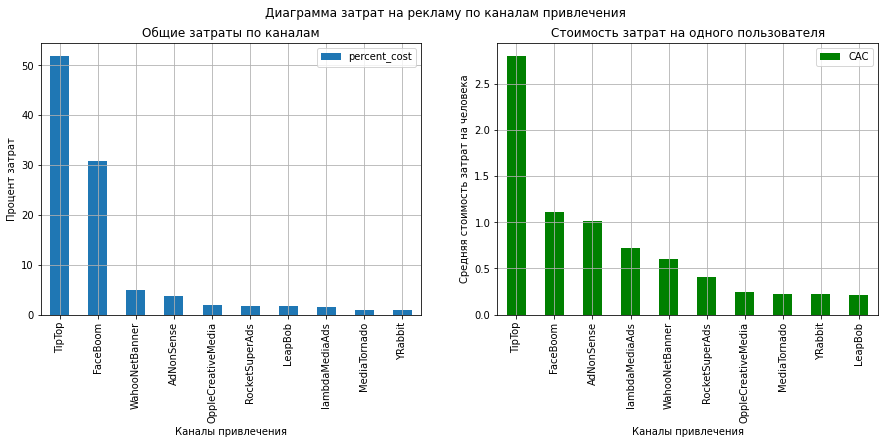

In [38]:
# построим диаграмму затрат на рекламу по каналам привлечения:
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Диаграмма затрат на рекламу по каналам привлечения")

ax1 = plt.subplot(1, 2, 1)
channel_costs['percent_cost'].plot(kind = 'bar', grid = True, xlabel = 'Каналы привлечения', 
                        ylabel = 'Процент затрат', title = 'Общие затраты по каналам')
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
channel_costs['CAC'].sort_values(ascending = False).plot(kind = 'bar', grid = True, xlabel = 'Каналы привлечения', 
            ylabel = 'Средняя стоимость затрат на человека', color = 'green', title = 'Стоимость затрат на одного пользователя')
ax2.legend()

plt.show()

Как мы видим, больше всего затрат приходится на рекламные источник Североамериканского региона: `TipTop` (51.90% всех затрат, 2.80 - стоимость одного пользователя) и `FaceBoom` (30.75% всех затрат, 1.11 - стоимость одного пользователя). Эти платформы представлены только в США, и т.к большая часть пользователей находится именно там, логично, что будут привлекать пользователей именно в этом регионе. Такая реклама обходится дороже всего, затраты на рекламу в США - более 82% всего рекламного бюджета, что опять же обуславливается региональной принадлежностью пользователей. 

Популярные европейские источники рекламы- `WahooNetBanner`(4.88%) и `AdNonSense` (3.71%) находятся на 3 и 4 месте по затратам. Средняя стоимость пользователя  `AdNonSense` сравнима с `FaceBoom` (1.01 / 1.11), что опять же обуславливается популярностью площадки в своем регионе. 

На остальные 6 источников приходится менее 9% рекламного бюджета, стоимость привлечения клиентов в этих источниках будет ниже, нежели у лидеров. 

Посмотрим, как изменялись рекламные затраты помесячно: 

<AxesSubplot:title={'center':'Ежемесячные затраты на рекламу'}, xlabel='Месяц', ylabel='Сумма затрат'>

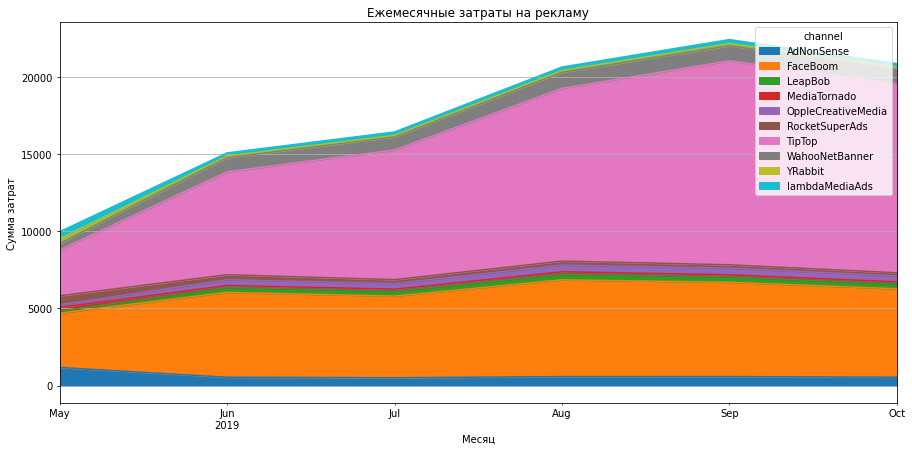

In [39]:
profiles_adv.pivot_table(columns = 'channel', index = 'month', values = 'acquisition_cost', 
                aggfunc = 'sum').plot.area(grid = True, figsize = (15, 7), title = 'Ежемесячные затраты на рекламу', 
                                        xlabel = 'Месяц', ylabel = "Сумма затрат")

Если посмотреть график ежемесячных затрат на рекламу, видно: 
- Траты на рекламу растут непрерывно с мая по сентябрь. В октябре наблюдается небольшой спад, но это можно объяснить тем, что выгрузка за октябрь- не полная (до 27.10)
- Больше всего на рекламу потратили в сентябре (ок. 22000), далее - в августе и октябре (ок. 21000). Думаю, эти месяцы являются "пиковыми" для сферы, активность пользователей в этой время выше, поэтому и расходы на рекламу целесообразнее было повысить.
- Траты в мае - минимальны (10000)
- Июнь и июль отмечаются примерно одинаковыми расходами (15000- 16000).
- Самые затратные источники рекламы - популярные источники в США `FaceBoom` и  `TipTop`.

Уберем из нашей выборки США, как регион-гегемон (если сделать выборку по всем регионам, затраты на рекламу в США заглушат Европейский регион) и построим график рекламных затрат по Европе: 

<AxesSubplot:title={'center':'Ежемесячные затраты на рекламу'}, xlabel='Месяц', ylabel='Сумма затрат'>

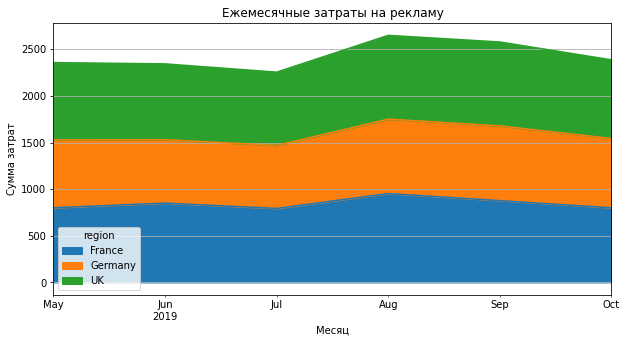

In [40]:
profiles_adv.query('region != "United States"').pivot_table(columns = 'region', index = 'month', 
                values = 'acquisition_cost', aggfunc = 'sum').plot.area(grid = True, figsize = (10, 5),
                title = 'Ежемесячные затраты на рекламу', xlabel = 'Месяц', ylabel = "Сумма затрат")

По этому графику видно, траты в Европе практически не меняются в зависимости от страны. В среднем, здесь прослеживается общая тенденция- меньше всего трат на рекламу было в июле, больше всего- в августе и сентябре. В среднем траты на Европу не превышают 3000 в месяц, что в среднем соответствует доле общего рынка в 25-30%.

## 4.2 Расчет среднего САС и САС по источникам
Выше был рассчитан САС по источникам привлечения (`channel_costs['CAC']`), а также средний САС. Построим график:

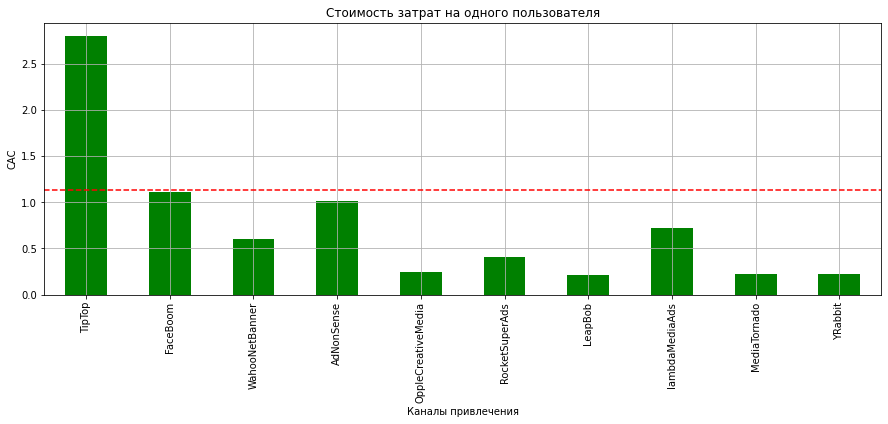

In [41]:
fig = plt.figure(figsize=(15, 5))
ax1 = channel_costs['CAC'].plot(kind = 'bar', grid = True, xlabel = 'Каналы привлечения', 
            ylabel = 'CAC', color = 'green', title = 'Стоимость затрат на одного пользователя')
plt.axhline(y=profiles_adv['acquisition_cost'].mean(), color='red', linestyle='--', label='Средний САС')


График подтверждает, что популярные источники рекламы стоят дороже или на уровне среднего САС. Как я писала выше, средний САС составляет 1.127, один из лидеров привлечения (`TipTop`)- стоит намного выше среднего, `AdNonSense` и `FaceBoom` - на уровне среднего САС. Еще одна популярная платформа для Европы - `WahooNetBanner` обходится меньше, чем средний САС, однако ее доля в общих затратах не столь велика. 

### Вывод: 
В ходе рекламной кампании за полгода была потрачена значительная сумма - 105497.0. Т.к. большая часть пользователей находится в США, расходы на рекламу в этом регионе очень велики (ок. 80% всех рекламных затрат приходится на популярные в США источники: `TipTop` (51.90%) и `FaceBoom` (30.75%). На популярные Европейские источники приходится всего лишь 9% от рекламных затрат (`WahooNetBanner`(4.88%) и `AdNonSense` (3.71%)). Средний САС по всей выборке составляет 1.127, однако все популярные источники размещения, кроме `WahooNetBanner`, обходятся как минимум на уровне среднего САС. Лидер по затратам - `TipTop` (САС для этого источника почти в 3 раза выше среднего: 2.80/1.127). 

Если посмотреть расходы на рекламу в разрезе ежемесячых трат, то пик трат приходится на август-октябрь. Траты на продвижение в рекламных источниках довольно стабильны, за исключением 2х самых популярных платформ из США: `FaceBoom` (траты хоть и не изменяются месяц от месяца, но довольно велики) и `TipTop` (самые большие рекламные затраты, увеличиваются месяц к месяцу). Платформа `TipTop` имеет не только самый большой рекламный бюджет, но и самый высокий САС, что подразумевает следующее: платформа не приносит столько пользователей, сколько нужно, чтобы "опустить" САС хотя бы до уровня среднего. Возможно, в тратах на эти два источника и есть загвоздка- почему рекламная кампания не окупается. Проанализируем окупаемость рекламы и найдем, в чем же проблема

# 5. Оценка окупаемости рекламы для привлечения пользователей
## 5.1 Анализ общей окупаемости рекламы по графикам LTV и ROI

Проведем анализ общей окупаемости рекламы по графикам LTV и ROI. 
Зададим момент и горизонт анализа, а затем применим функцию `get_ltv()` для нахождения LTV и ROI.
В [п.3](#organic) были исследованы рекламные источники привлечения пользователей и было выяснено, что на канал `organic` приходится около 37% от всего объема привлечения клиентов. Я считаю, что это большая доля и присутствие данного канала может исказить все показатели. Поэтому будем использовать `profiles_adv` (профили без органики)

In [42]:
observation_date = datetime(2019, 11, 1).date()      # момент анализа
horizon_days = 14   # горизонт анализа
profiles_adv = profiles.query('channel != "organic"')

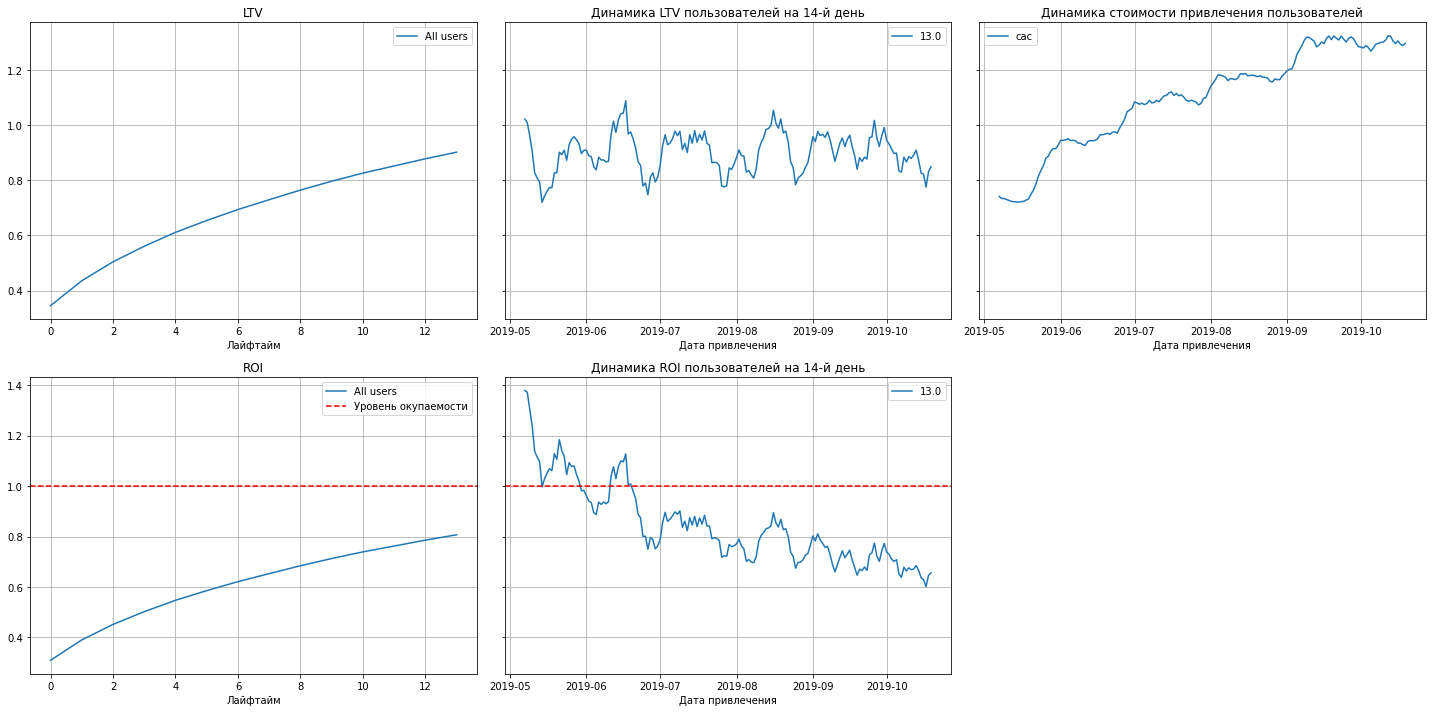

In [43]:
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles_adv, 
                                                                               orders, observation_date, horizon_days)
#создаем таблицы: с сырыми данными, с LTV и ROI в динамике и без

plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

Изучив построенные графики можно сделать следующие выводы: 

- LTV - кривая плавно плавно растет от нуля, значит верно выбраны момент и горизонт анализа. Сам показатель довольно стабилен, значит нет ухудшения качества пользователей.  
- LTV в динамике - неоднороден, есть как максимальные значения (например, у пользователей с датой привлечения в середине июля и середине августа), так и спады (конец июня, конец июля, конец августа). Возможно, есть какая-то "сезонность" в работе, т.е. периоды, когда потребители менее заинтересованы в продукте. 
- САС растет, а соответственно, растут расходы на рекламу (рост в октябре в сравнении с маем - около 50%).
- ROI не пересекает уровень окупаемости (в нашем случае он равен 1) - значит реклама не окупается. 
- ROI в динамике падает, однако по графику можно утверждать, что до начала июня реклама окупалась (график динамики ROI выше уровня окупаемости). В июне было пиковое значение ROI в середине июня (совпадает с пиком на графике динамики LTV), далее показатель стабильно падает от месяца к месяцу. 

Чтобы разобраться в причинах неокупаемости рекламы, посмотрим срезы по параметрам: рекламные каналы, страны, устройства. 

## 5.2 Анализ общей окупаемости рекламы по графикам LTV и ROI с разбивкой по устройствам.

Как было указано в [разделе 3](#region), рекламные каналы и предпочитаемые пользователями устройства имеют свои региональные особенности - что-то предпочитают только в Европе, а что-то иное- исключительно в США. Для более детальной проработки анализа напишем функцию `region_name()`, которая создаст в таблице `profiles_adv` столбец `region_name` с флагом принадлежности страны к региону- US или EU. Это поможет в дальнейшем сделать анализ с привязкой региона. 

In [44]:
def region_name(region):
    if region == 'United States':
        return 'US'
    
    return 'EU'

In [45]:
profiles_adv['region_name'] = profiles_adv['region'].apply(region_name)
profiles_adv.head()

/tmp/ipykernel_106/2647371203.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_adv['region_name'] = profiles_adv['region'].apply(region_name)


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,region_name
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,US
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237,US
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235,EU
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769,US
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000,EU


Для анализа по устройствам используем всю ту же функцию `get_ltv()`. Параметр `dimensions` в этот раз зададим как `device`

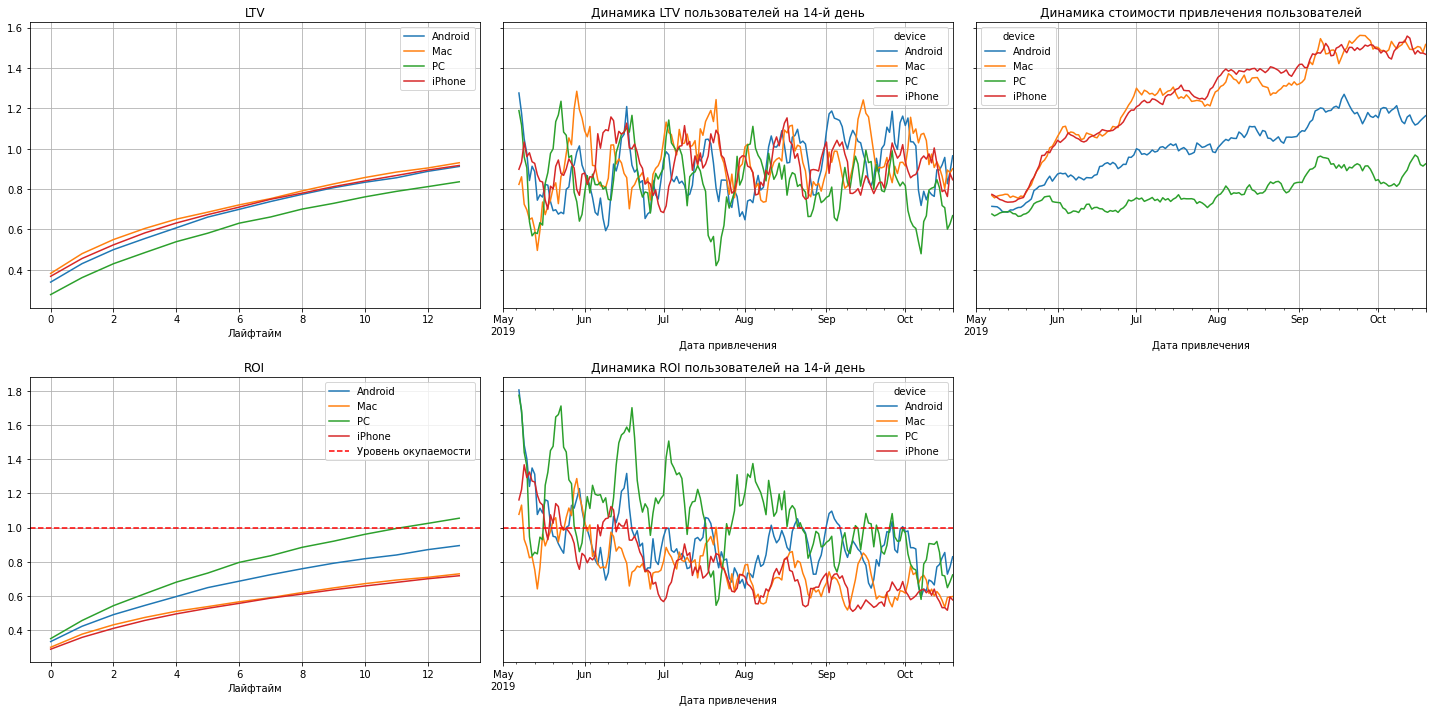

In [46]:
#изучаем графики с разбивкой по устройствам: 
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles_adv, 
                                                            orders, observation_date, horizon_days, dimensions = ['device'])
#создаем таблицы: с сырыми данными, с LTV и ROI в динамике и без

plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

Если проанализировать графики, можно сказать следующее: 

- "Пожизненная ценность" клиента с РС ниже, чем у клиента с Android, MAC или IPhone. Но сам параметр `LTV` все так же стабилен. 
- Стоимость привлечения клиента растет, однако меньше всего параметр САС опять же для устройств PC, дороже всего обзоходится реклама для MAC и IPhone. САС для устройств  Android - посередине. 
- Реклама начинает окупаться после 12 дня (11 lifetime) для РС. Предполагаю, что это связано с низким параметром САС для этого устройства. 
- Для всех остальных устройств реклама не окупается, затраты на рекламу значительные. 

Изучим графики с разбивкой не только по устройству, но и по региону (US/EU):

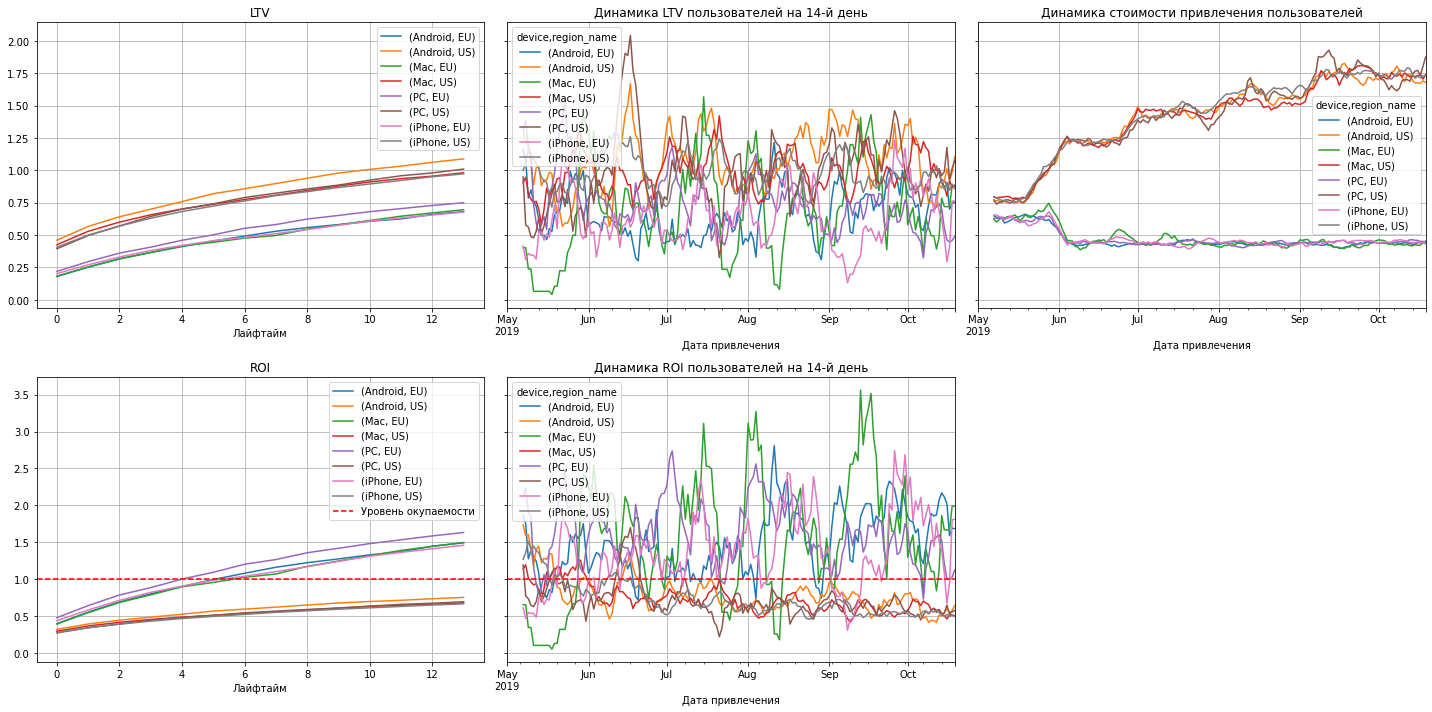

In [47]:
#изучаем графики с разбивкой по устройствам и регионам: 
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles_adv, 
                                            orders, observation_date, horizon_days, dimensions = ['device', 'region_name'])
#создаем таблицы: с сырыми данными, с LTV и ROI в динамике и без

plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

Если посмотреть график с разбивкой по регионам - ситуация меняется. <a id='device_region'></a>
- LTV для пользователей Североамериканского региона выше, чем для Европейских пользователей (для всех устройств). Разница значительная- до 40-50%. 
- Однако и САС различается значительно. Примерно до середины мая затраты на рекламу для регионов US и EU были крайне близки, с середины мая начинается резкий рост затрат на рекламу в US и понижение затрат на рекламу EU в июне по сравнению с маем. (опять же, для всех устройств). Затраты на рекламу в США растут от месяца к месяцу и в несколько раз превышают затраты на рекламу в Европе. 
- Если посмотреть на график ROI, то Европейские пользователи начинают окупаться с 7 дня, пользователи из США не окупаются. Выше всего ROI для пользователей РС из Европы. 

## 5.2 Анализ общей окупаемости рекламы по графикам LTV и ROI с разбивкой по странам
Для выяснения причин неокупаемости рекламы проанализируем график с разбивкой по странам. 

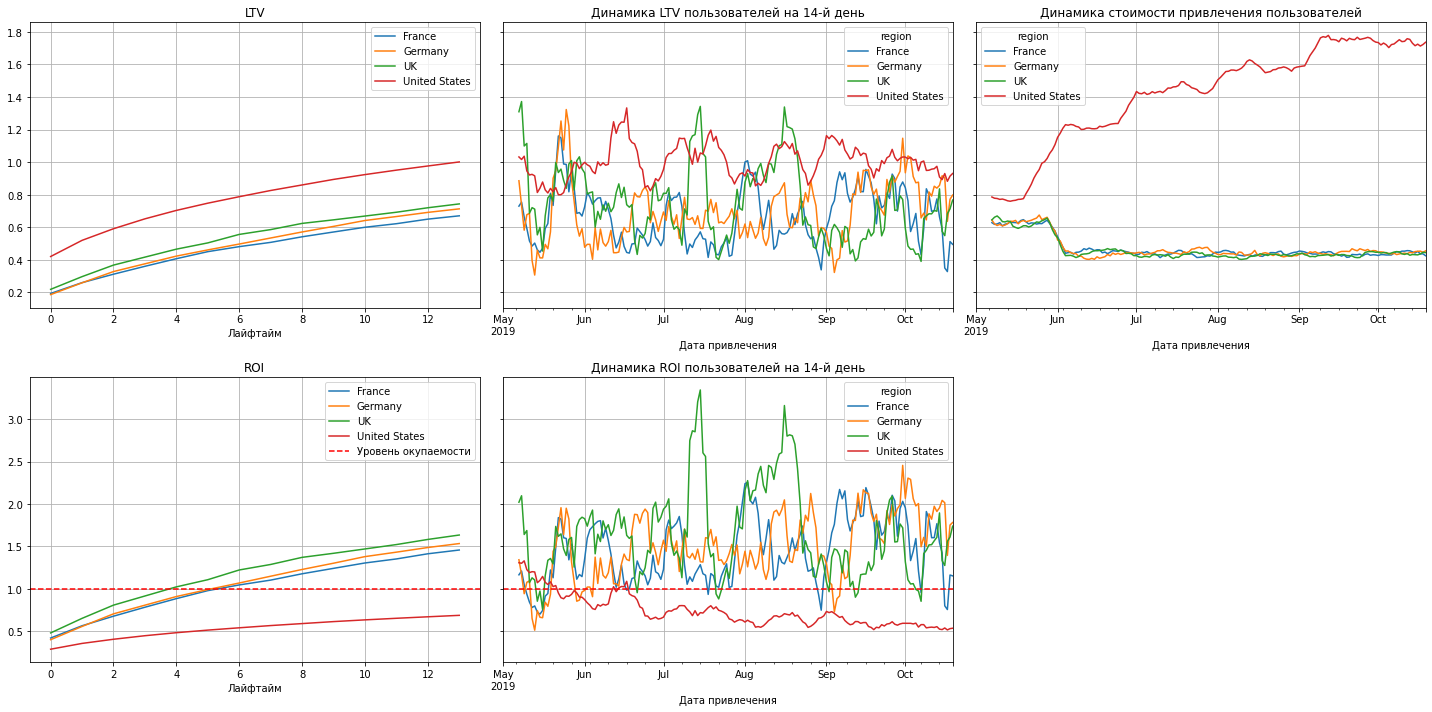

In [48]:
#изучаем графики с разбивкой по устройствам и регионам: 
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles_adv, 
                                            orders, observation_date, horizon_days, dimensions = ['region'])
#создаем таблицы: с сырыми данными, с LTV и ROI в динамике и без

plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

График с разбивкой по странам подтверждает все то, что я писала [ранее](#device_region). 
Выше всего LTV для пользователей из США, однако реклама для этих пользователей не окупается, в отличие от пользователей из Европы. Если посмотреть на динамику ROI, графики довольно похожи для всех европейских стран, однако для Великобритании имеются всплески ROI в середине июля и августа. 

Необходимо проанализировать рекламные каналы, чтобы посмотреть, как распределены затраты на рекламу из разных источников. 

## 5.3 Анализ общей окупаемости рекламы по графикам LTV и ROI с разбивкой по рекламным каналам

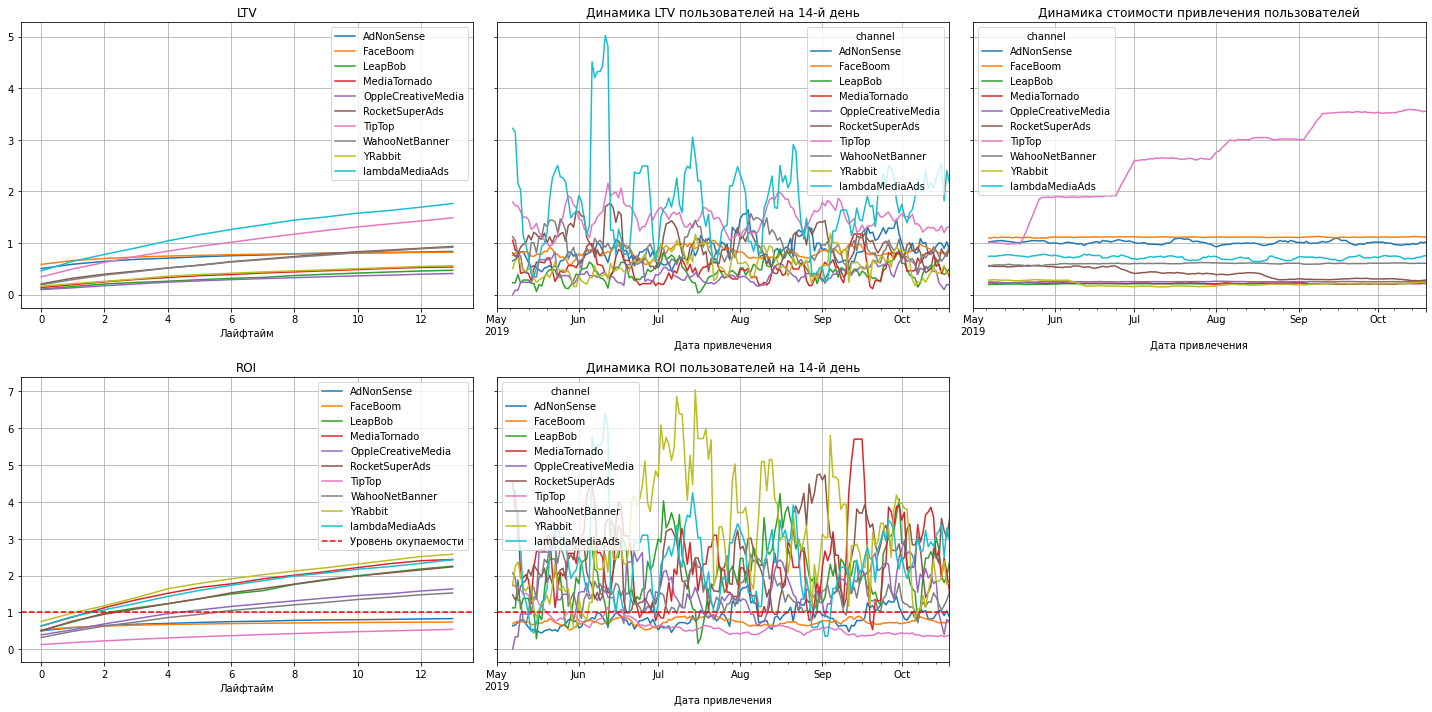

In [49]:
#изучаем графики с разбивкой по устройствам и регионам: 
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles_adv, 
                                            orders, observation_date, horizon_days, dimensions = ['channel'])
#создаем таблицы: с сырыми данными, с LTV и ROI в динамике и без

plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

Изучив графики рекламных источников, можно сказать следующее:
- LTV выше всего у источника `LambdaMediaADS`, который занимает всего около 1.5% от общих рекламных затрат. На графике динамики LTV этот источник также дает пиковые значения. Второй по значению LTV - у источника `Tip-Top`, который популярен в США.
- САС для `Tip-Top` больше, чем затраты на иные источники и постоянно растет. Для всех остальных источников затраты на рекламу постоянны. 
- Не окупается реклама для `TipTop` и `FaceBoom` (США), а также для `AdNonSence` (EU), реклама во всех других источниках окупается. 

Сделаем срез данных для интересующих источников и проанализируем рекламные затраты по этим источникам: 

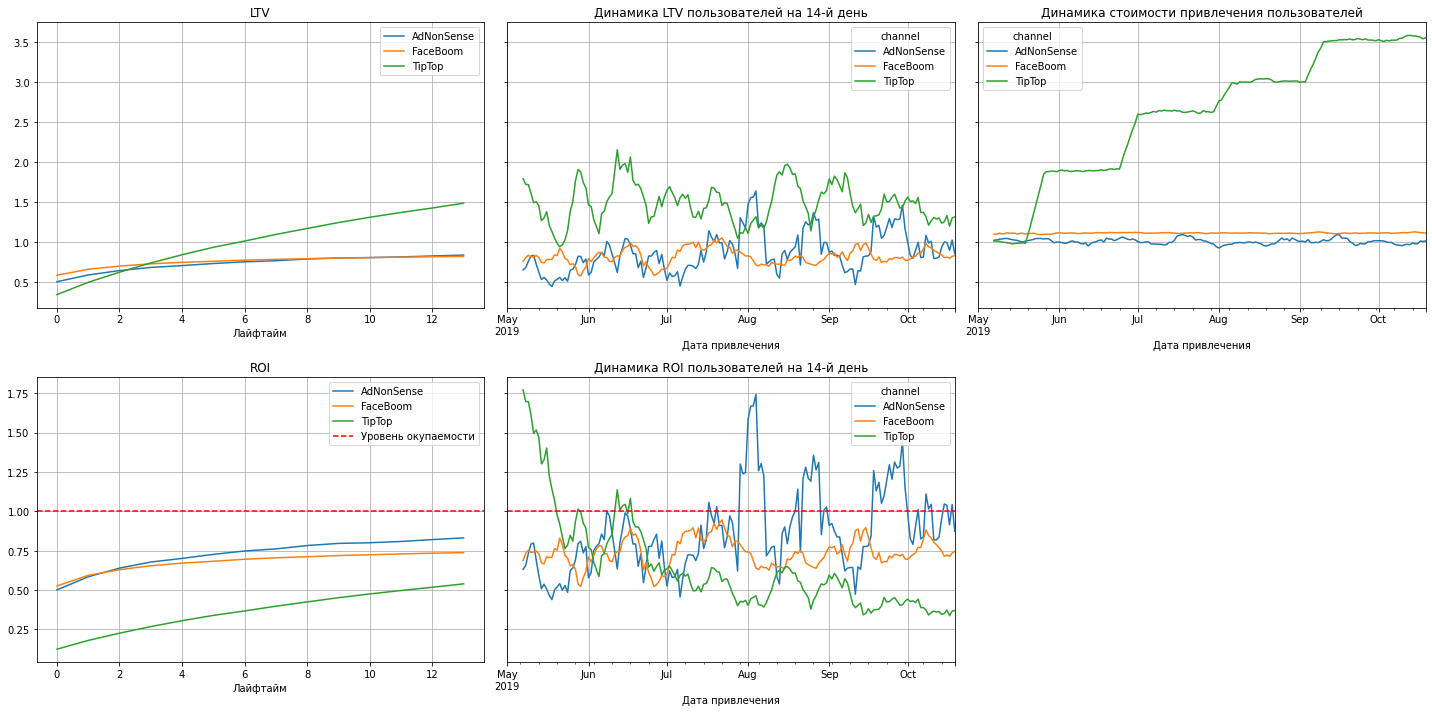

In [50]:
adv = ['FaceBoom', 'TipTop', 'AdNonSense'] #делаем срез для интересующих источников
adv_channel = profiles_adv.query('channel in @adv')

#изучаем графики с разбивкой по устройствам и регионам: 
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(adv_channel, 
                                            orders, observation_date, horizon_days, dimensions = ['channel'])
#создаем таблицы: с сырыми данными, с LTV и ROI в динамике и без

plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

Кажется, найдена причина неокупаемости: выбранные нами 3 самых популярных канала привлечения не окупаются, стоимость рекламных затрат намного превышают жизненную стоимость пользователя. 
Как видно из графика САС, затраты на рекламу `Tip-Top` растут ежемесячно и намного превышают LTV- график ROI по этому источнику намного ниже, чем уровень окупаемости. 
Затраты на рекламу `FaceBoom` и `AdNonSence` стабильны, но также не превышают уровень LTV по данным каналам, что также не дает пересечь уровень окупаемости. 
Маркетинговому отделу необходимо обратить внимание на рекламу в данных источниках - снизить расходы или, возможно, прекратить пользоваться данными рекламными источниками.

## 5.4 Анализ конверсии в зависимости от различных параметров
Для окончательной формулировки выводом изучим конверсию при помощи функции `get_conversion()`
Параметр `dimensions` пока опустим.

Из графика без параметров видно, что конверсия стабильно растет. Найти причину проблемы по такому графику- невозможно. 

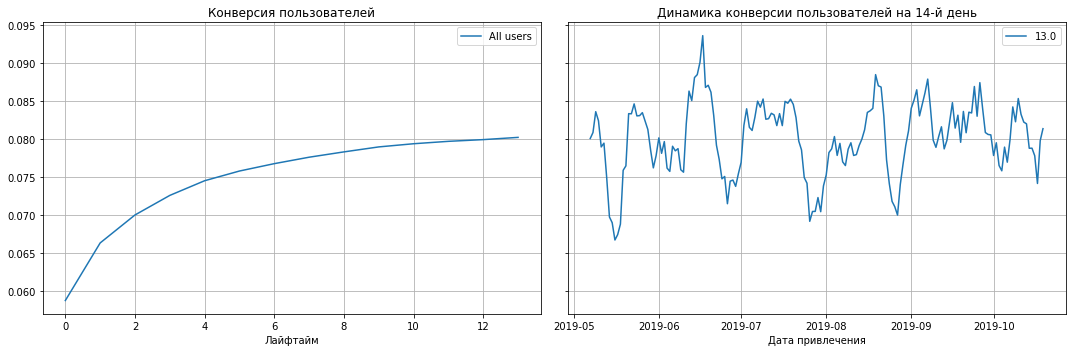

In [51]:
conv_raw, conv_grouped, conv_in_time = get_conversion(profiles_adv, orders, observation_date, horizon_days)
plot_conversion(conv_grouped, conv_in_time, horizon_days, window=7)

Посмотрим конверсию с разбивкой по регионам. 
Выше всего конверсия в США по сравнению с Европой (разница примерно в 2 раза). 
Если посмотреть конверсию с разбивкой по стране и устройству, то все равномерно, нет выбивающихся значений - конверсия на всех устройствах из США выше конверсии всех устройств в Европе. 

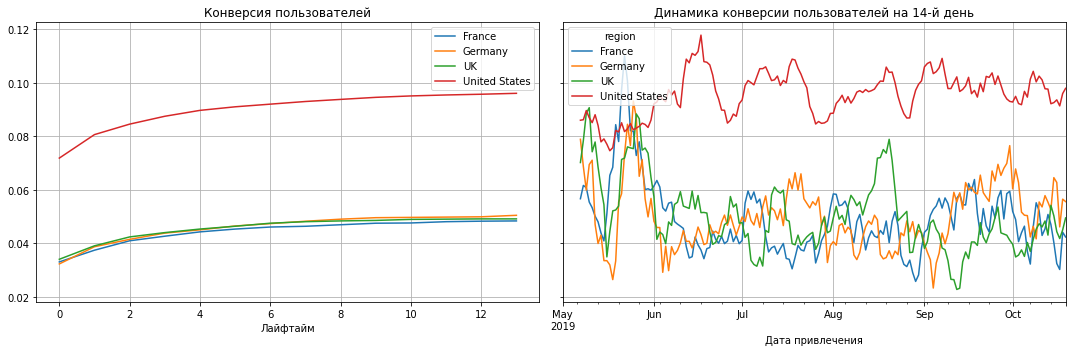

In [52]:
conv_raw, conv_grouped, conv_in_time = get_conversion(profiles_adv, 
                                                      orders, observation_date, horizon_days, dimensions = ['region'])
plot_conversion(conv_grouped, conv_in_time, horizon_days, window=7)

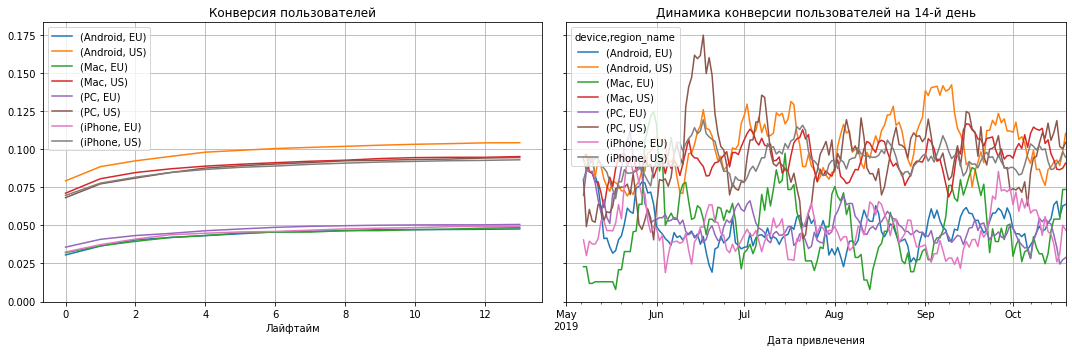

In [53]:
conv_raw, conv_grouped, conv_in_time = get_conversion(profiles_adv, 
                                        orders, observation_date, horizon_days, dimensions = ['device', 'region_name'])
plot_conversion(conv_grouped, conv_in_time, horizon_days, window=7)

Если посмотреть конверсию с разбивкой по каналам, то больше всего покупателей приносят `FaceBoom` и `AdNonSence`, однако, как я писала ранее, реклама в этих источниках не окупается. 
Лидер рекламных вливаний `Tip-Top` - на 4м месте по конверсии. 

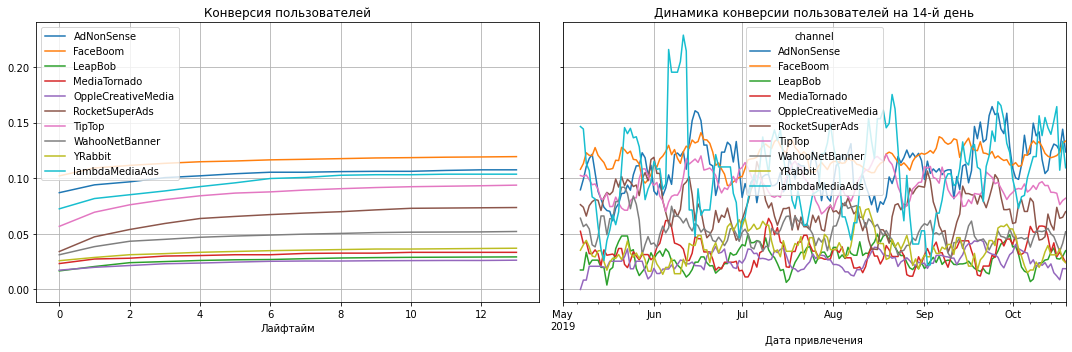

In [54]:
conv_raw, conv_grouped, conv_in_time = get_conversion(profiles_adv, 
                                        orders, observation_date, horizon_days, dimensions = ['channel'])
plot_conversion(conv_grouped, conv_in_time, horizon_days, window=7)

## 5.5 Анализ удержания в зависимости от различных параметров

Используем функцию `get_retention` и изучим удержание пользователей в зависимости от различных параметров.
Для начала рассмотрим общий график удержания **без акцента на отдельные параметры.** 

Как видно, удержание пользователей неуклонно падает день ото дня (как обычно, удержание платящих пользователей лучше, чем у неплатящих). На 14 день (конец лайфтайма) удержание неплатящих падает практически до 0, платящих- сохраняется на уровне 0,1 - 0,125.
Зададим параметр `dimensions = ['device']` и посмотрим, зависит ли удержание от устройства пользователя.

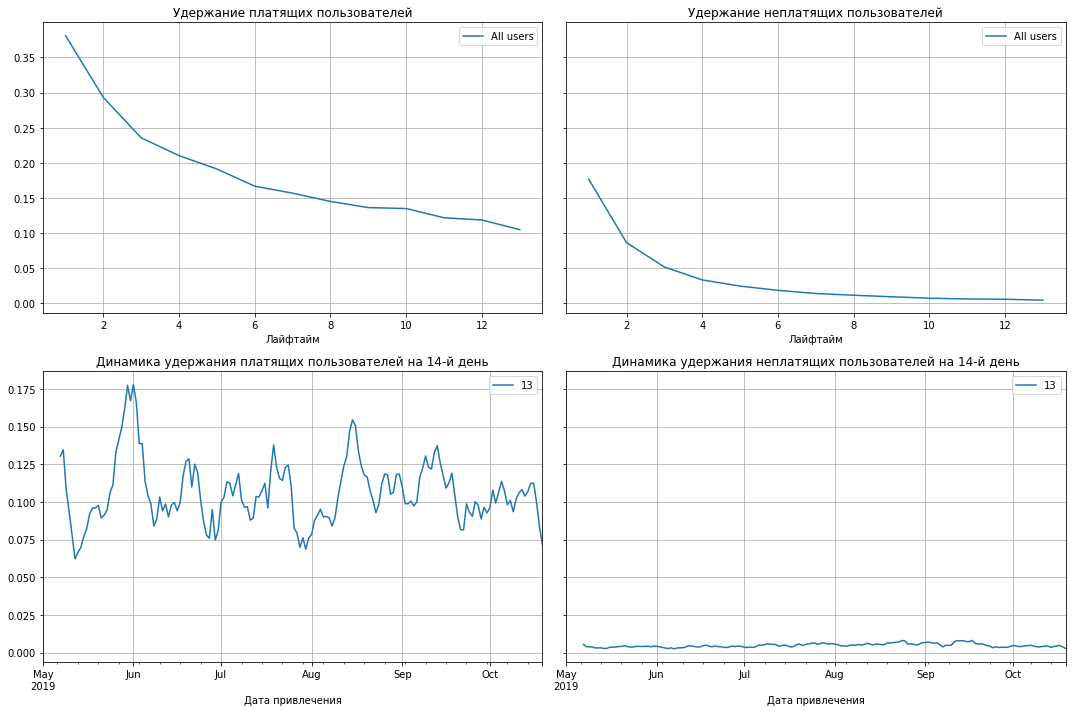

In [55]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_adv, visits, observation_date, horizon_days)
plot_retention(retention_grouped, retention_in_time, horizon_days)

Если задать параметр `dimensions = ['device']`, то видно, что удержание все так же падает. Среди платящих пользователей лучше всего удерживаются пользователи РС, однако это различие не очень велико. 

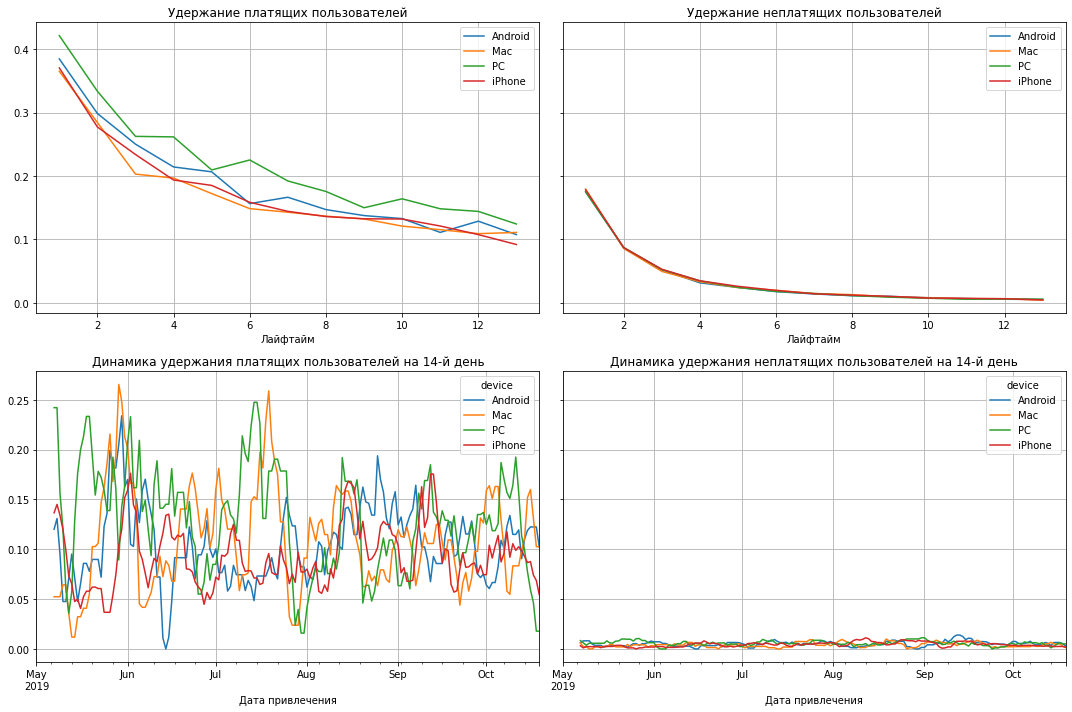

In [56]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_adv, visits, 
                                                                    observation_date, horizon_days, dimensions = ['device'])
plot_retention(retention_grouped, retention_in_time, horizon_days)

Если задать параметр `dimensions = ['region']`, то заметно, что удержание платящих пользователей в США намного ниже, чем в Европе. Низкое удержание пользователей и есть причина провала рекламной кампании, т.к. при всей массе приходящих клиентов их удержание недостаточное, чтобы "отбить" рекламную кампанию. 

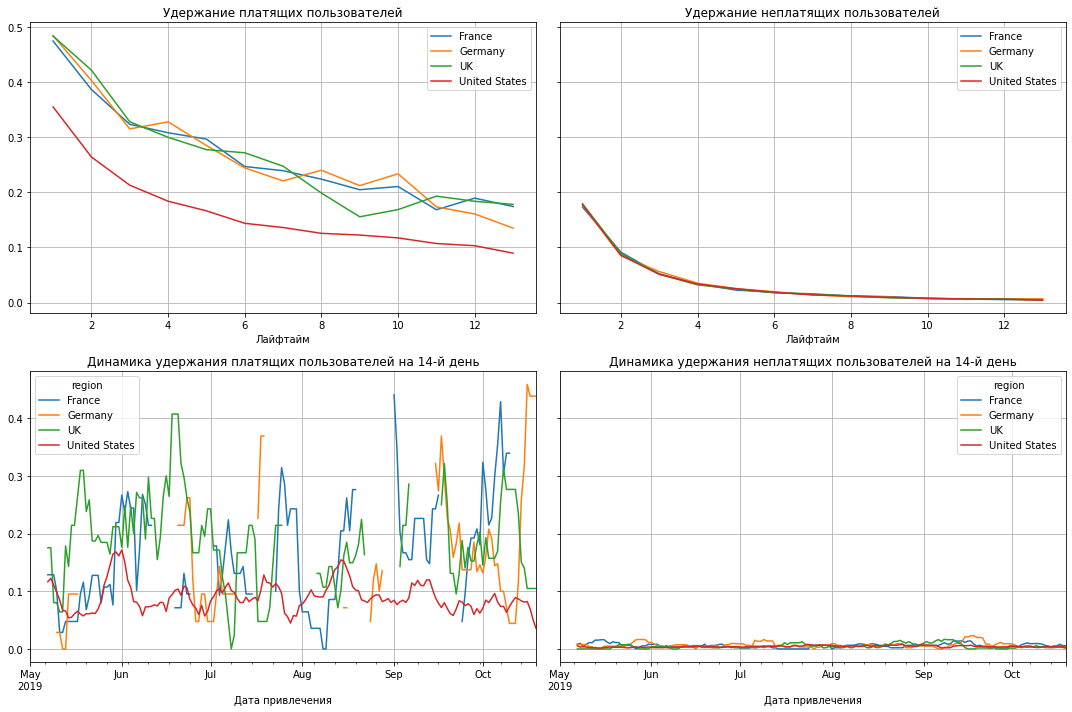

In [57]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_adv, visits, 
                                                    observation_date, horizon_days, dimensions = ['region'])
plot_retention(retention_grouped, retention_in_time, horizon_days)

Если мы построим тепловую карту по параметру `dimensions = ['region_name']` (т.е. без разбивки по странам, только по региону), заметно следующее: 
- Удержание неплатящих пользователей невелико (ок. 18% во 2 день) и падает по экспоненте (на 7й день уровень удержания таких пользователей уже ок. 2%).
- Удержание платящих пользователей намного выше и падает не так резко.
- Удержание пользователей из Европы ощутимо выше, чем у пользователей из США (48,03%/35.48% на второй день, 16.34%/8.95% на 14 день). 

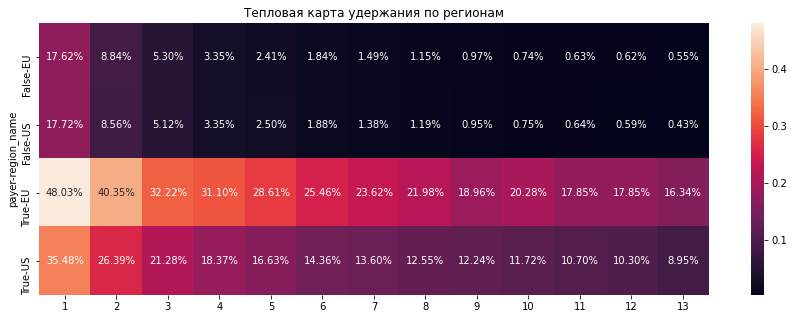

In [58]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_adv, visits, 
                                                    observation_date, horizon_days, dimensions = ['region_name'])

plt.figure(figsize=(15, 5))
sns.heatmap(retention_grouped.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания по регионам')
plt.show() 

Посмотрим, как зависит удержание от **рекламных источников** (`dimensions = ['channel']`). 
Здесь видно, что самое маленькое удержание у самых популярных источников: `FaceBoom` и `AdNonSence`. Удержание по этим источникам настолько невелико, что находится на уровне удержания для неплатящих пользователей(!). По остальным источникам удержание намного выше, в т.ч. и по еще одному популярному источнику `TipTop`.

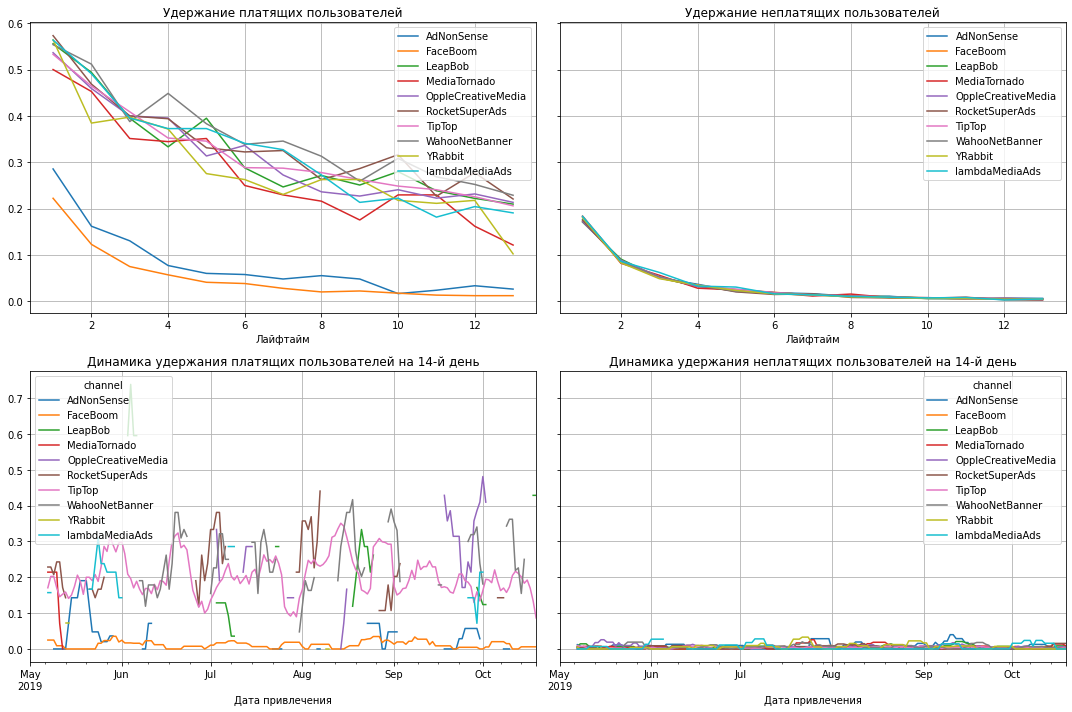

In [59]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_adv, visits, 
                                                    observation_date, horizon_days, dimensions = ['channel'])
plot_retention(retention_grouped, retention_in_time, horizon_days)

Ранее я делала срез датафрейма `profiles` по трем самым популярным рекламным источникам (`TipTop`, `FaceBoom`, `AdNonSence`) - `adv_channel`. Посмотроим тепловую карту удержания по этим источникам.
Картина выходит нерадостная - только платящие пользователи, пришедшие по каналу `TipTop`, имеют высокое удержание на весь лайфтайм. По всем остальным источникам - удержание очень быстро падает (для неплатящих - не более 2% на 7й день, для платящих: `AdNonSence` - 28.57% на 2 день и 5.81% на 7 день; `FaceBoom` - 22.25% на 2 день и 2.83% на 7 день). 
Вообще уровень удержания платных пользователей для `AdNonSence` и `FaceBoom` соизмерим с показателями тех же площадок для неплатящих пользователей, что может говорить о провале рекламной кампании на этих площадках. 

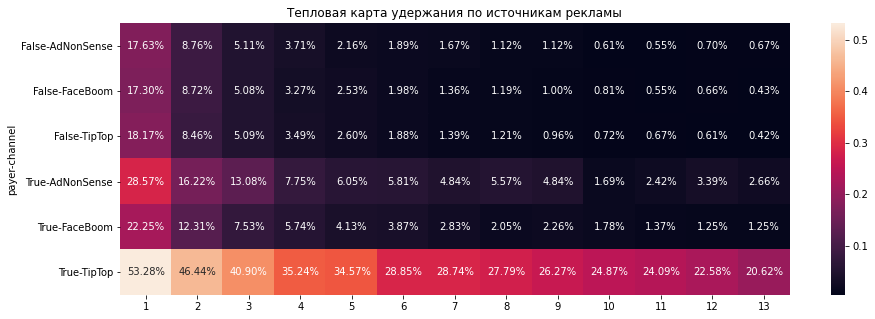

In [60]:
retention_raw, retention_grouped, retention_in_time = get_retention(adv_channel, visits, observation_date, 
                                                            horizon_days, dimensions = ['channel'])

plt.figure(figsize=(15, 5))
sns.heatmap(retention_grouped.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания по источникам рекламы')
plt.show() 

# 6. Выводы и рекомендации

В ходе проекта были исследованы данные о рекламной компании приложения `Procrastinate Pro+` и получены следующие результаты:
- Около 66% пользователей приложения находятся в США, остальная часть приходится на страны Европы (Германия, Франция, Великобритания), у этих же пользователей самая высокая конверсия (ок. 7%). 
- Самым популярным устройством для входа является IPhone. 
- Более 82% от общих затрат на рекламу приходится на источники в США: `FaceBoom` (конверсия - 12.20%) и `TipTop` (конверсия - 9.60%). Остальные 18% затрат- реклама в Европе, где лидерами по затратам являются `WahooNetBanner`(конверсия - 5.30%) и `AdNonSence` (конверсия - 11.34%). 
- Средний САС по всем источникам составляет 1.127. Если изучить стоимость привлечения пользователей с разбивкой по каналам, то выяснится, что дороже всех обходятся пользователи `TipTop` (2.80), `FaceBoom` (1.11) и `AdNonSence` (1.10).

При общем анализе графиков LTV и ROI выяснилось: 
- Стоимость привлечения пользователей неуклонно растет, что указывает на рост рекламных затрат. 
- Рекламная кампания не окупается, т.к. показатель ROI намного ниже уровня окупаемости
- ROI в динамике показывает нам, что ROI неуклонно падал, но до начала июня рекламная кампания окупалась, а затем пересекла линию безубыточности и окупаться перестала. 

Для выяснения причин были изучены графики LTV и ROI, а также конверсия и удержание в зависимости от различных параметров (устройства, страны, рекламные каналы). 
- По графику ROI с разбивкой по устройствам видно, что окупается только рекламная кампания для РС (с 12 дня), другие устройства не окупаются вовсе.
- Рекламная кампания для США не окупается, для Европы - окупается с 7 дня. 
- С середины мая резко возрастают рекламные расходы для США, и наоборот - падают для Европы. Далее рекламные расходы в Европе остаются стабильными, для США- быстро растут. 
- График ROI с разбивкой по рекламным каналам указывает на то, что не окупаются самые дорогие каналы привлечения пользователей- 
`TipTop`, `FaceBoom` и `AdNonSence`, все остальные- окупаются. 
- Конверсия пользователей из США намного больше, чем Европейских, однако с удержанием обратная ситуация - оно намного ниже, чем в Европе. 

При рассмотрении самых дорогих рекламных источников получили следующее: 
`TipTop` : высокий LTV, высокая конверсия, но самый низкий ROI среди всех источников, самые большие траты на рекламу. 
`FaceBoom`: низкий LTV, самая высокая конверсия, низкий ROI, рекламные траты большие, но стабильные. 
`AdNonSence`: низкий LTV, самая высокая конверсия, низкий ROI, рекламные траты стабильные. 

Считаю, что лучше всего удалась реклама на европейском канале `lambdaMediaAds` - при небольших затратах на рекламу (САС - 0.72, это намного ниже среднего) этот канал дал хорошую конверсию (ок. 10%), высокий LTV и ROI, реклама окупается с 3 дня. 

**Используя полученные данные, можно сформулировать причины неэффективности привлечения пользователей**: 
Начиная с середины мая упор был сделан на массовую аудиторию США, для этого был многократно увеличен рекламный бюджет на рекламу в этом регионе. Таким образом, ощутимо возросла конверсия пользователей из этого региона, а вот удержание наоборот ощутимо меньше, чем у пользователей из Европы. Если посмотреть тепловую карту удержания пользователей, то заметно, что удержание Европейских пользователей намного больше и стабильнее, чем у пользователей из США. Тепловая карта удержания с разбивкой по каналам дает еще более угнетающую информацию: из всех трех источников только `Tip-Top` дает удержание платящих клиентов, ощутимо превышающее удержание неплатящих. Удержание платящих пользователей из источников `FaceBoom` и `AdNonSence` сопоставимо с неплатящими, что в принципе лишает смысла рекламные кампании в этих источниках. Это значит, что заказчик рекламной кампании заплатил за рекламу в этих источниках и получил массу зарегистрировавших пользователей с высокой конверсией, но не смог их удержать. 

**Рекомендации для повышения эффективности:**
- Необходимо найти бреши в удержании пользователей - почему они уходят? Возможно, дело в региональной особенности восприятия контента - ведь реклама окупается в Европе и приложение популярно. Возможно, пользователей из США это приложение не заинтересовывает. Необходимо выяснить предпочтения пользователей из США и "примерить" их на свое приложение.
- Необходимо снизить расходы на рекламу в США до уровня начала мая 2019 г., когда рекламная кампания окупалась и решить проблему из предыдущего пункта, далее возобновить рекламную кампанию. 
- Пересмотреть подход к рекламным источникам и поставить вопрос о целесообразности рекламы в `TipTop`, `FaceBoom` и `AdNonSence`. 
- Необходимо доработать приложение для `РС`, чтобы поднять конверсию с этого устройства до уровня других устройств. 
- **Для США:** возможно, стоит снизить расходы на рекламу в `TipTop` (САС одного клиента в 4 раза выше среднего САС), но не отказываться от нее, т.к аудитория из этого источника имеет хорошее удержание. Реклама в `FaceBoom` малоэффективна, так что ее стоит приостановить. Думаю, что стоит также рассмотреть возможность увеличения рекламного бюджета в других источниках рекламы с неплохой конверсией, например - `RocketSuperAds` (7.91%). Этот источник также имеет неплохой LTV и окупается с 3 дня. 
- **Для Европы:** Рекламу в `AdNonSence` стоит приостановить и рассмотреть вопрос размещения в других источниках (например, в показавшем себя с хорошей стороны `lambdaMediaAds` или популярном в Европе `WahooNetBanner`, САС которых ниже среднего). Однако для выбора приоритетного источника следует произвести детальный анализ. 